In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

##### ---------------------------------------------------------
### 1. SETUP & REPRODUCIBILITY
##### ---------------------------------------------------------

In [11]:
# As requested, setting the seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


##### ---------------------------------------------------------
### 2. SYNTHETIC DATASET GENERATION
##### ---------------------------------------------------------

In [5]:
class SyntheticHairDataset(Dataset):
    """
    Creates a synthetic dataset with shape (3, 200, 200) to resemble
    the Hair Type dataset inputs for binary classification.
    """
    def __init__(self, num_samples=100):
        self.num_samples = num_samples
        # Generate random noise images: (Num_samples, Channels, Height, Width)
        # Using standard normal distribution
        self.data = torch.randn(num_samples, 3, 200, 200)
        
        # Generate binary labels (0 or 1)
        # float32 is required for BCELoss
        self.labels = torch.randint(0, 2, (num_samples,)).type(torch.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create dataset and dataloader
# Batch size kept low because the specific architecture creates a large linear layer
BATCH_SIZE = 16 
dataset = SyntheticHairDataset(num_samples=200)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

##### ---------------------------------------------------------
### 3. MODEL ARCHITECTURE
##### ---------------------------------------------------------

In [6]:
class HairClassifier(nn.Module):
    def __init__(self):
        super(HairClassifier, self).__init__()
        
        # 1. Input shape is (3, 200, 200)
        
        # 2. Convolutional Layer
        # Input: 3 channels, Output: 32 channels, Kernel: 3x3
        # Default stride=1, padding=0
        # Output H/W formula: (Input + 2*padding - kernel) / stride + 1
        # H_out = (200 - 3) / 1 + 1 = 198
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        
        # 3. Max Pooling
        # Kernel: 2x2
        # H_out = 198 / 2 = 99
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # 4. Flatten
        self.flatten = nn.Flatten()
        
        # Calculate size for linear layer input
        # Feature map shape is now (32, 99, 99)
        self.flat_features = 32 * 99 * 99  # 313,632 features
        
        # 5. Linear Layer 1
        self.fc1 = nn.Linear(self.flat_features, 64)
        
        # 6. Output Layer (Binary)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convolution Block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Dense Block
        x = self.fc1(x)
        x = self.relu(x)
        
        # Output Block
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
model = HairClassifier().to(device)

# Print architecture summary to verify shapes
print(model)

HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


##### ---------------------------------------------------------
### 4. OPTIMIZER & LOSS
##### ---------------------------------------------------------

In [7]:
# Binary Cross Entropy Loss is standard for binary classification with Sigmoid output
criterion = nn.BCELoss()

# SGD Optimizer as requested
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

##### ---------------------------------------------------------
### 5. TRAINING LOOP
##### ---------------------------------------------------------

In [8]:
num_epochs = 5
loss_history = []

print("\nStarting Training...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1) # Reshape label to (batch, 1) to match output
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        epoch_loss += loss.item()
        
        # Calculate accuracy (threshold 0.5)
        predicted = (outputs > 0.5).float()
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
        
    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct_preds / total_preds
    loss_history.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training Complete.")


Starting Training...
Epoch [1/5], Loss: 0.8141, Accuracy: 0.5500
Epoch [2/5], Loss: 0.6936, Accuracy: 0.4900
Epoch [3/5], Loss: 0.6930, Accuracy: 0.5200
Epoch [4/5], Loss: 0.6937, Accuracy: 0.4300
Epoch [5/5], Loss: 0.6881, Accuracy: 0.5900
Training Complete.


##### ---------------------------------------------------------
### 6. VISUALIZATION (Optional)
##### ---------------------------------------------------------

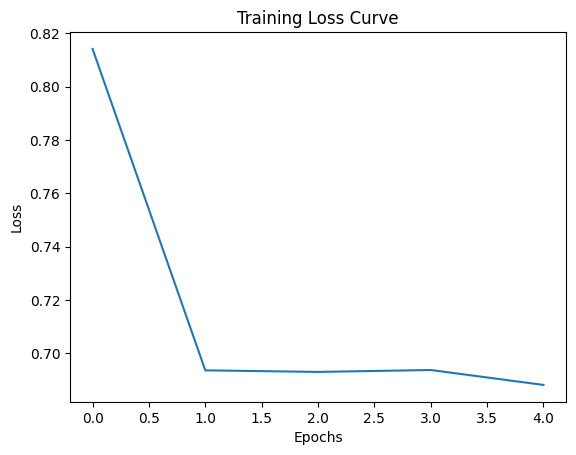

In [9]:
plt.plot(loss_history)
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Important Implementation Notes**
1. **Architecture Math:**
    * Input: 200 x 200
    * After Conv2d (3x3, no padding): 198 x 198
    * After MaxPool (2x2): 99 x 99
    * This results in a massive flattening layer (32 x 99 x 99 = 313,632 inputs). This creates a very large weight matrix for the first Linear layer. I have implemented it exactly as requested, but in a production environment, you would typically add more Convolutional/Pooling blocks to reduce the image size further before flattening.

2. **Activation:** I used nn.Sigmoid at the end because we are doing binary classification (1 neuron). Consequently, the loss function used is nn.BCELoss.

3. **Data:** Since we cannot download files directly, I created the SyntheticHairDataset class. To use your real Kaggle data later, you would simply replace this class with torchvision.datasets.ImageFolder or a custom class that loads your JPG/PNG files.